In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display, HTML
from scipy.ndimage import zoom

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [5]:
#Checking for non-numeric or null columns
dataset_path = './MHealth Dataset/Data/BaseFiles/MHealth_Cleaned_Dataset.csv'
data = pd.read_csv(dataset_path)
print("Data types in the dataset:\n", data.dtypes)
print("Summary of missing values:\n", data.isnull().sum())
print("First few rows of the dataset:\n", data.head())

Data types in the dataset:
 user                                int64
Activity                           object
acceleration_chest_x              float64
acceleration_chest_y              float64
acceleration_chest_z              float64
ECG_1                             float64
ECG_2                             float64
acceleration_left_ankle_x         float64
acceleration_left_ankle_y         float64
acceleration_left_ankle_z         float64
gyro_left_ankle_x                 float64
gyro_left_ankle_y                 float64
gyro_left_ankle_z                 float64
magnetometer_left_ankle_x         float64
magnetometer_left_ankle_y         float64
magnetometer_left_ankle_z         float64
acceleration_right_lower_arm_x    float64
acceleration_right_lower_arm_y    float64
acceleration_right_lower_arm_z    float64
gyro_right_lower_arm_x            float64
gyro_right_lower_arm_y            float64
gyro_right_lower_arm_z            float64
magnetometer_right_lower_arm_x    float64
magnet

In [6]:
# keeping 'Activity' column to its base data type & convert other columns to numeric because of further training options.
activity_column = data['Activity']
features = data.drop(columns=['Activity'])
features = features.apply(pd.to_numeric, errors='coerce')# converting data types to numeric and handling errors by forcing changes to NaN
features = features.dropna() #dropping nan values

# Check if features DataFrame is empty after cleaning
if features.shape[0] == 0:
    raise ValueError("No valid data available after cleaning. Please check the dataset.")
features['Activity'] = activity_column

# Set GAN parameters
latent_dim = 10
num_epochs = 10
batch_size = 64

# Define the generator network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# Training the GAN
def train_gan(data, latent_dim=10, num_epochs=10, batch_size=64, learning_rate=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = data.shape[1] - 1  # Exclude the 'Activity' column
    generator = Generator(latent_dim, input_dim).to(device)
    discriminator = Discriminator(input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    feature_data = data.drop(columns=['Activity']) 
    dataset = TensorDataset(torch.tensor(feature_data.values, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(num_epochs):
        for i, real_data in enumerate(dataloader):
            real_data = real_data[0].to(device)
            # Training on real data and generating fake data
            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels[:real_data.size(0)])
            real_score = outputs
            z = torch.randn(real_data.size(0), latent_dim).to(device)
            fake_data = generator(z)
            # Training fake data
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels[:real_data.size(0)])
            fake_score = outputs
            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()
            # Training generator with real and fake data
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels[:real_data.size(0)])
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

    return generator

# Generate synthetic data using the trained GAN
def generate_synthetic_data(generator, num_samples, latent_dim):
    if num_samples <= 0:
        raise ValueError(f"num_samples should be a positive integer, but got num_samples={num_samples}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = torch.randn(num_samples, latent_dim).to(device)
    synthetic_data = generator(z)
    return synthetic_data.cpu().detach().numpy()

# Set the number of synthetic samples
num_synthetic_samples = int(features.shape[0] * 0.1)
# validate num_synthetic_samples is positive
if num_synthetic_samples <= 0:
    raise ValueError(f"Generated num_synthetic_samples is non-positive: {num_synthetic_samples}. Check the data size.")

# Train the GAN
generator = train_gan(features, latent_dim, num_epochs=num_epochs, batch_size=batch_size)
synthetic_feature_data = generate_synthetic_data(generator, num_synthetic_samples, latent_dim)
synthetic_activities = np.random.choice(activity_column, num_synthetic_samples)
# Combine synthetic features with synthetic 'Activity' labels
synthetic_data_df = pd.DataFrame(synthetic_feature_data, columns=features.columns[:-1])  # Exclude the 'Activity' column
synthetic_data_df['Activity'] = synthetic_activities
data = pd.concat([data, synthetic_data_df], ignore_index=True)
# Save the augmented dataset
data.to_csv('./MHealth Dataset/Data/Advanced/MHealth_GAN_Dataset.csv', index=False, float_format='%.2f')
# Split the augmented data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Activity'])
# Save the train and test datasets
train_data.to_csv('./MHealth Dataset/Data/Advanced/MHealth_GAN_train_data.csv', index=False, float_format='%.2f')
test_data.to_csv('./MHealth Dataset/Data/Advanced/MHealth_GAN_test_data.csv', index=False, float_format='%.2f')


In [7]:
# Load the augmented dataset
data = pd.read_csv('./MHealth Dataset/Data/Advanced/MHealth_GAN_Dataset.csv')
duplicates = data.duplicated().sum()  #Checking for duplicates
nulls = data.isnull().sum().sum() # Checking for null
print(f"Number of duplicates in the augmented dataset: {duplicates}")
print(f"Number of null values in the augmented dataset: {nulls}")
augmented_data = data.drop_duplicates() # Remove duplicates if any
print(f"Shape after removing duplicates: {augmented_data.shape}")
# Check class balance
class_distribution = augmented_data['Activity'].value_counts()
print("Class distribution in the augmented dataset:")
print(class_distribution)

Number of duplicates in the augmented dataset: 0
Number of null values in the augmented dataset: 0
Shape after removing duplicates: (55000, 25)
Class distribution in the augmented dataset:
Activity
No_activity                  39175
Standing_still                1486
Jogging                       1467
Lying_down                    1453
Jumping_front_back            1449
Running                       1443
Sitting_and_relaxing          1427
Climbing_stairs               1392
Walking                       1376
Frontal_elevation_of_arms     1347
Waist_bends_forward           1326
Knees_bending                 1209
Cycling                        450
Name: count, dtype: int64


In [8]:
# Step 1: Splitting the data into features (X) and labels (Y)
X_GAN = augmented_data.drop(columns=['Activity'])
Y_GAN = augmented_data['Activity']
# Encode labels
label_encoder = LabelEncoder()
Y_encoded_GAN = label_encoder.fit_transform(Y_GAN)
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X_GAN, Y_encoded_GAN, test_size=0.2, random_state=42, stratify=Y_encoded_GAN)


In [9]:
def choosingDatasetForTrainingModel(TechModel):
    if TechModel == 'GAN':  # Load the GAN-augmented dataset
        train_data = pd.read_csv('./MHealth Dataset/Data/Advanced/MHealth_GAN_train_data.csv')
        test_data = pd.read_csv('./MHealth Dataset/Data/Advanced/MHealth_GAN_test_data.csv')  
    if TechModel == 'CPC':  # Load the CPC-augmented dataset
        train_data = pd.read_csv('./MHealth Dataset/Data/Advanced/MHealth_CPC_train_data.csv')
        test_data = pd.read_csv('./MHealth Dataset/Data/Advanced/MHealth_CPC_test_data.csv')
    X_train = train_data.drop(columns=['Activity'])
    Y_train = train_data['Activity']
    X_test = test_data.drop(columns=['Activity'])
    Y_test = test_data['Activity']
    # Encode the labels
    label_encoder = LabelEncoder()
    Y_train_encoded = label_encoder.fit_transform(Y_train)
    Y_test_encoded = label_encoder.transform(Y_test)
    return X_train,X_test,Y_train_encoded,Y_test_encoded

In [10]:
def trainAndtestdatasheet(TechModel,modelsName, MHealth_X_Train, MHealth_X_Test):
    match TechModel:
        case 'GAN':
            X_train,X_test,Y_train_encoded,Y_test_encoded=choosingDatasetForTrainingModel('GAN')
        case 'CPC':  
            X_train,X_test,Y_train_encoded,Y_test_encoded=choosingDatasetForTrainingModel('CPC')  
    if modelsName == 'LSTM':
        MHealth_X_Train = np.expand_dims(X_train.values, axis=1)
        MHealth_X_Test = np.expand_dims(X_test.values, axis=1)
    else:
        MHealth_X_Train = np.expand_dims(X_train.values, axis=-1)
        MHealth_X_Test= np.expand_dims(X_test.values, axis=-1)

    return MHealth_X_Train, MHealth_X_Test,Y_train_encoded,Y_test_encoded


In [11]:
#Consolidating all results in single csv(accuracy,F1 Score)
def getAccuracyAndF1Score(Advance,ModelName,Accuracy,F1Score):
    if not os.path.exists('./MHealth Dataset/results'):
        os.makedirs('./MHealth Dataset/results')

    result = {
        "Advance Class":Advance,
        "Model": ModelName,
        "Accuracy": Accuracy,
        "F1 Score": F1Score
    }
    file_path = './MHealth Dataset/results/results.csv'
    df_result = pd.DataFrame([result])
    if os.path.exists(file_path):
        df_result.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df_result.to_csv(file_path, mode='w', header=True, index=False)
        print(f"File {file_path} created and results logged.")

In [12]:
def TrainingModelAndGeneratingReport(TechModel,TrainingModelName,ModelsName):
    ModelAccuracy = 0.0
    ModelClassificationDataFrame = pd.DataFrame
    MHealth_X_Train,MHealth_X_Test,Y_train_encoded,Y_test_encoded = trainAndtestdatasheet(TechModel,ModelsName,X_train, X_test)
    if (ModelsName =='LSTM' or ModelsName =='CNN'):  
        TrainingModelName.fit(MHealth_X_Train, Y_train_encoded, epochs=10, batch_size=64, validation_split=0.2)
        ModelPrediction = np.argmax(TrainingModelName.predict(MHealth_X_Test), axis=-1)
        ModelAccuracy = accuracy_score(Y_test_encoded, ModelPrediction) * 100
        ModelClassificationReport = classification_report(Y_test_encoded, ModelPrediction, target_names=label_encoder.classes_, output_dict=True)
        ModelClassificationDataFrame = pd.DataFrame(ModelClassificationReport).transpose()
        ModelClassificationDataFrame.loc['accuracy'] = [ModelAccuracy, '-', '-', '-']
        ModelF1Score = f1_score(Y_test_encoded, ModelPrediction, average='weighted')
    else:
        TrainingModelName.fit(X_train, Y_train_encoded)
        ModelPrediction = TrainingModelName.predict(X_test)
        ModelAccuracy = accuracy_score(Y_test_encoded, ModelPrediction) * 100
        ModelF1Score = f1_score(Y_test_encoded, ModelPrediction, average='weighted')
        ModelClassificationReport = classification_report(Y_test_encoded, ModelPrediction, target_names=label_encoder.classes_, output_dict=True)
        ModelClassificationDataFrame = pd.DataFrame(ModelClassificationReport).transpose()
        ModelClassificationDataFrame.loc['accuracy'] = [ModelAccuracy, '-', '-', '-']
    getAccuracyAndF1Score('Advance Class_'+TechModel,ModelsName,ModelAccuracy,ModelF1Score)
    ModelClassificationDataFrame = ModelClassificationDataFrame.round(2)
    ModelClassificationDataFrame.columns = [col.upper() for col in ModelClassificationDataFrame.columns]
    ModelClassificationDataFrame.index = [idx.upper() for idx in ModelClassificationDataFrame.index]

    #Displaying report
    Classification_Report_Display = ModelClassificationDataFrame.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
    ).format(precision=2)
    display(ModelsName+': Classification Report.')
    display(Classification_Report_Display)

    #Putting confusion matrix
    ModelConfusionmatrix= confusion_matrix(Y_test_encoded, ModelPrediction)
    plt.figure(figsize=(10, 8))
    sns.heatmap(ModelConfusionmatrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(Y_train), yticklabels=np.unique(Y_train))
    plt.title(ModelsName + ' MHealth : Confusion Matrix')
    plt.xlabel('PREDICTED LABEL')
    plt.ylabel('TRUE LABEL')
    plt.show()

In [13]:
def callModels(TechModel,ModelsName):
    print("\033[1;34m.....................................................!\033[0m")
    print('Running for Advanced '+ModelsName+'.....................>>>>>')
    print("\033[1;34m.....................................................!\033[0m")
    MHealth_X_Train, MHealth_X_Test,Y_train_encoded,Y_test_encoded = trainAndtestdatasheet(TechModel,ModelsName,X_train, X_test)
    match ModelsName.upper():
        case 'RANDOM FOREST':
            TrainingModelName = RandomForestClassifier(n_estimators=100, random_state=42)
            TrainingModelAndGeneratingReport(TechModel,TrainingModelName,ModelsName)
            
        case 'SVM':
            TrainingModelName = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, max_iter=10000)
            TrainingModelAndGeneratingReport(TechModel,TrainingModelName,ModelsName)
        case 'LSTM':
            TrainingModelName = models.Sequential([
            layers.LSTM(128, input_shape=(MHealth_X_Train.shape[1], MHealth_X_Train.shape[2])),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(label_encoder.classes_), activation='softmax')
        ])

            TrainingModelName.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            TrainingModelAndGeneratingReport(TechModel,TrainingModelName,ModelsName)

        case 'CNN': 
            TrainingModelName = models.Sequential([
            layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(MHealth_X_Train.shape[1], 1)),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(128, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(label_encoder.classes_), activation='softmax')
            ])
            # Compile with a smaller learning rate and Adam optimizer
            TrainingModelName.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            TrainingModelAndGeneratingReport(TechModel,TrainingModelName,ModelsName)
            
    

..........................TRAINING GAN...........................!
.....................................................!
Running for Advanced RANDOM FOREST.....................>>>>>
.....................................................!


'RANDOM FOREST: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.91,0.15,0.26,279.00
CYCLING,0.85,0.26,0.39,90.00
FRONTAL_ELEVATION_OF_ARMS,0.85,0.67,0.75,269.00
JOGGING,0.85,0.77,0.81,293.00
JUMPING_FRONT_BACK,0.86,0.71,0.78,290.00
KNEES_BENDING,0.87,0.46,0.60,242.00
LYING_DOWN,0.81,0.89,0.85,291.00
NO_ACTIVITY,0.87,0.95,0.91,7835.00
RUNNING,0.81,0.75,0.78,289.00
SITTING_AND_RELAXING,0.81,0.89,0.85,285.00


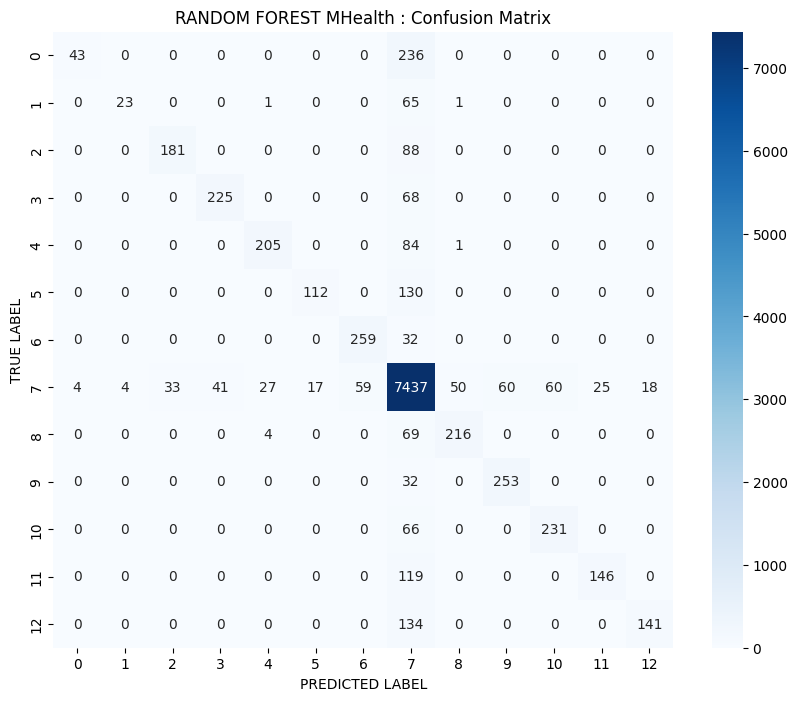

.....................................................!
Running for Advanced SVM.....................>>>>>
.....................................................!


'SVM: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.00,0.00,0.00,279.00
CYCLING,0.52,0.18,0.26,90.00
FRONTAL_ELEVATION_OF_ARMS,0.70,0.37,0.48,269.00
JOGGING,1.00,0.01,0.03,293.00
JUMPING_FRONT_BACK,0.70,0.64,0.67,290.00
KNEES_BENDING,0.00,0.00,0.00,242.00
LYING_DOWN,0.68,0.93,0.78,291.00
NO_ACTIVITY,0.77,0.96,0.85,7835.00
RUNNING,0.73,0.61,0.67,289.00
SITTING_AND_RELAXING,0.00,0.00,0.00,285.00


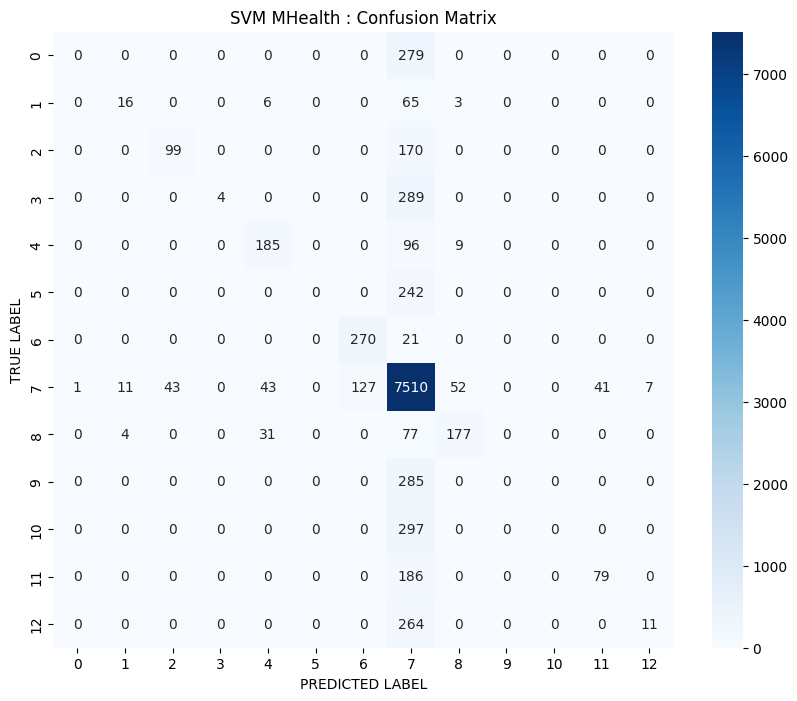

.....................................................!
Running for Advanced LSTM.....................>>>>>
.....................................................!
Epoch 1/10
550/550 [==============================] - 2s 2ms/step - loss: 0.8833 - accuracy: 0.7378 - val_loss: 0.7105 - val_accuracy: 0.7622
Epoch 2/10
550/550 [==============================] - 1s 1ms/step - loss: 0.6349 - accuracy: 0.7780 - val_loss: 0.6494 - val_accuracy: 0.7743
Epoch 3/10
550/550 [==============================] - 1s 1ms/step - loss: 0.5809 - accuracy: 0.7931 - val_loss: 0.6156 - val_accuracy: 0.7783
Epoch 4/10
550/550 [==============================] - 1s 1ms/step - loss: 0.5478 - accuracy: 0.8020 - val_loss: 0.6097 - val_accuracy: 0.7789
Epoch 5/10
550/550 [==============================] - 1s 1ms/step - loss: 0.5210 - accuracy: 0.8124 - val_loss: 0.5848 - val_accuracy: 0.7858
Epoch 6/10
550/550 [==============================] - 1s 1ms/step - loss: 0.5030 - accuracy: 0.8178 - val_loss: 0.5843 - val_acc

'LSTM: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.62,0.25,0.36,279.00
CYCLING,0.48,0.12,0.19,90.00
FRONTAL_ELEVATION_OF_ARMS,0.69,0.64,0.66,269.00
JOGGING,0.71,0.68,0.69,293.00
JUMPING_FRONT_BACK,0.60,0.57,0.59,290.00
KNEES_BENDING,0.66,0.46,0.54,242.00
LYING_DOWN,0.72,0.87,0.79,291.00
NO_ACTIVITY,0.85,0.90,0.88,7835.00
RUNNING,0.63,0.51,0.56,289.00
SITTING_AND_RELAXING,0.71,0.77,0.74,285.00


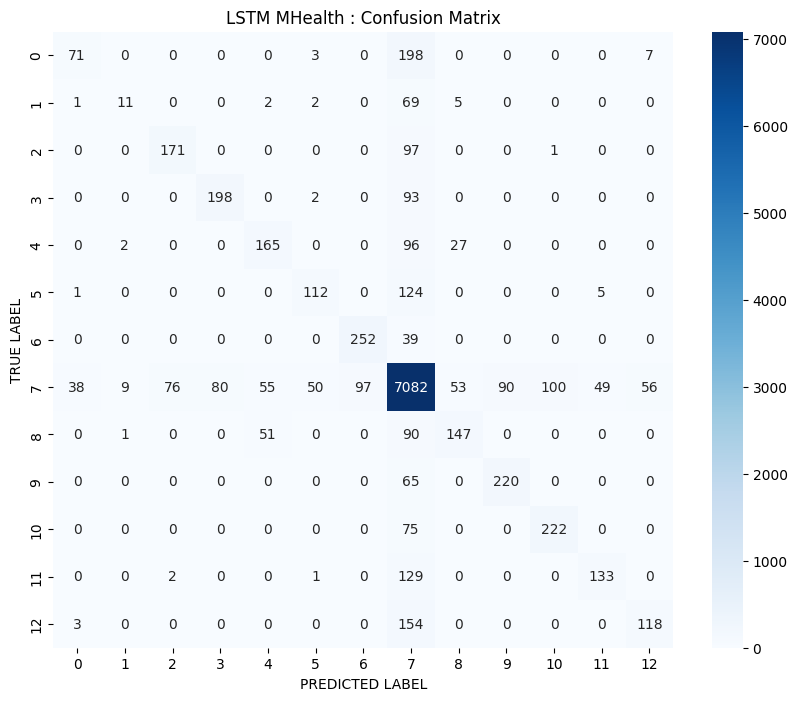

.....................................................!
Running for Advanced CNN.....................>>>>>
.....................................................!
Epoch 1/10
550/550 [==============================] - 2s 2ms/step - loss: 0.9719 - accuracy: 0.7303 - val_loss: 0.7986 - val_accuracy: 0.7444
Epoch 2/10
550/550 [==============================] - 1s 2ms/step - loss: 0.7209 - accuracy: 0.7604 - val_loss: 0.7457 - val_accuracy: 0.7474
Epoch 3/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6614 - accuracy: 0.7703 - val_loss: 0.6857 - val_accuracy: 0.7689
Epoch 4/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6269 - accuracy: 0.7772 - val_loss: 0.6425 - val_accuracy: 0.7675
Epoch 5/10
550/550 [==============================] - 1s 2ms/step - loss: 0.6001 - accuracy: 0.7842 - val_loss: 0.6123 - val_accuracy: 0.7743
Epoch 6/10
550/550 [==============================] - 1s 2ms/step - loss: 0.5775 - accuracy: 0.7884 - val_loss: 0.6018 - val_accu

'CNN: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.55,0.29,0.38,279.00
CYCLING,0.39,0.32,0.35,90.00
FRONTAL_ELEVATION_OF_ARMS,0.68,0.54,0.60,269.00
JOGGING,0.65,0.69,0.67,293.00
JUMPING_FRONT_BACK,0.68,0.36,0.47,290.00
KNEES_BENDING,0.76,0.33,0.47,242.00
LYING_DOWN,0.70,0.93,0.80,291.00
NO_ACTIVITY,0.83,0.90,0.87,7835.00
RUNNING,0.67,0.62,0.64,289.00
SITTING_AND_RELAXING,0.73,0.84,0.78,285.00


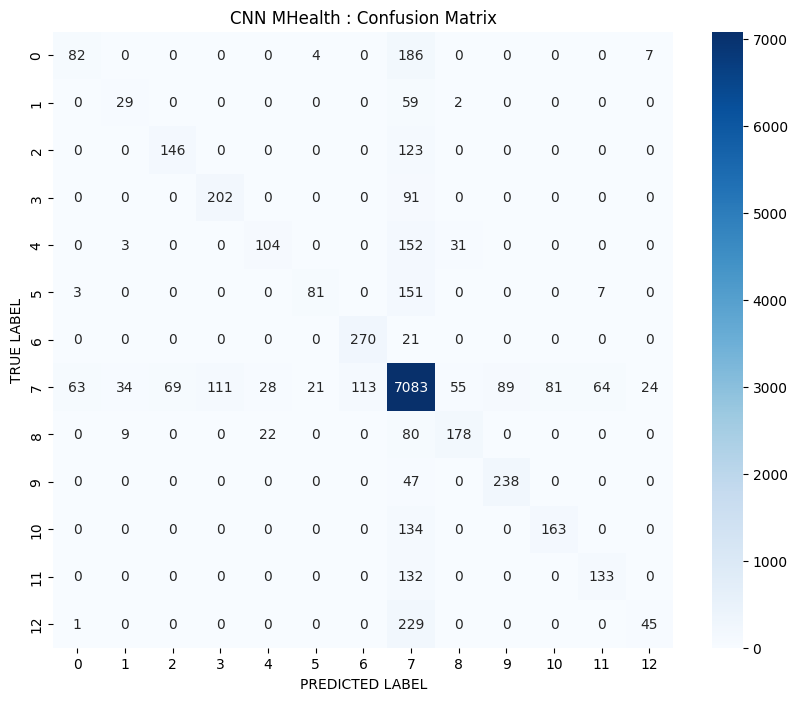

In [14]:
print("\033[1;32m..........................TRAINING GAN...........................!\033[0m")
callModels('GAN','RANDOM FOREST')
callModels('GAN','SVM')
callModels('GAN','LSTM')
callModels('GAN','CNN')

In [15]:
# Load the MHealth dataset
cpc_data_path = './MHealth Dataset/Data/BaseFiles/MHealth_Cleaned_Dataset.csv'  # Adjust the path if necessary
cpc_data = pd.read_csv(cpc_data_path)
X_cpc_data = cpc_data.drop(columns=['Activity'])
train_data = X_cpc_data.values.reshape(-1, 1, X_cpc_data.shape[1])

# Encoder_Network
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.model(x)

# Autoregressive_Model
class AutoregressiveModel(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoregressiveModel, self).__init__()
        self.model = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        output, _ = self.model(x)
        return output

#Contrastive Predictive Coding Model
class CPC(nn.Module):
    def __init__(self, encoder, autoregressive_model, hidden_dim, num_steps):
        super(CPC, self).__init__()
        self.encoder = encoder
        self.autoregressive_model = autoregressive_model
        self.Wk = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_steps)])
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        z = self.encoder(x.view(-1, x.size(-1))).view(batch_size, seq_len, -1)
        c = self.autoregressive_model(z)
        return c, z
    def contrastive_loss(self, c, z, num_steps):
        batch_size, seq_len, _ = z.size()
        loss = torch.tensor(0.0, device=z.device, requires_grad=True)  # Start with a tensor that tracks gradients
        for k in range(1, num_steps + 1):
            if k >= seq_len:
                continue  # Skip if k exceeds the sequence length
            z_k = z[:, k:seq_len, :]
            c_k = c[:, :(seq_len - k), :]
            Wk_zk = torch.matmul(z_k, self.Wk[k - 1].weight.t())
            Wk_zk = Wk_zk.view(batch_size, -1, z_k.size(-1))
            logits = torch.matmul(c_k, Wk_zk.permute(0, 2, 1))
            labels = torch.arange(c_k.size(1)).long().to(c.device)
            step_loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.repeat(batch_size))
            loss = loss + step_loss  # Accumulate the loss as a tensor operation

        loss = loss / num_steps  # Average the loss
        return loss

# Training the CPC model
def train_cpc(data, hidden_dim=128, num_steps=5, num_epochs=100, batch_size=64, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = data.shape[2]

    encoder = Encoder(input_dim, hidden_dim).to(device)
    autoregressive_model = AutoregressiveModel(hidden_dim).to(device)
    cpc_model = CPC(encoder, autoregressive_model, hidden_dim, num_steps).to(device)

    optimizer = optim.Adam(cpc_model.parameters(), lr=learning_rate)
    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for x in dataloader:
            x = x[0].to(device)
            c, z = cpc_model(x)
            loss = cpc_model.contrastive_loss(c, z, num_steps)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

    return cpc_model, encoder

# Generating representations using CPC
def generate_cpc_representations(cpc_model, data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cpc_model.eval()
    with torch.no_grad():
        data = torch.tensor(data, dtype=torch.float32).to(device)
        c, z = cpc_model(data)
        return z.cpu().numpy()

# Set hyperparameters for CPC training
hidden_dim = 562
num_steps = 5
num_epochs = 100
batch_size = 64
cpc_model, encoder = train_cpc(train_data, hidden_dim, num_steps, num_epochs, batch_size)
cpc_representations = generate_cpc_representations(cpc_model, train_data)
cpc_representations_df = pd.DataFrame(cpc_representations.reshape(cpc_representations.shape[0], -1))
cpc_representations_df.to_csv('./MHealth Dataset/Data/Advanced/MHealth_CPC_Dataset.csv', index=False, float_format='%.2f')


Epoch [10/100], Loss: 0.0
Epoch [20/100], Loss: 0.0
Epoch [30/100], Loss: 0.0
Epoch [40/100], Loss: 0.0
Epoch [50/100], Loss: 0.0
Epoch [60/100], Loss: 0.0
Epoch [70/100], Loss: 0.0
Epoch [80/100], Loss: 0.0
Epoch [90/100], Loss: 0.0
Epoch [100/100], Loss: 0.0


In [16]:
# Load the CPC representations
cpc_representations_df = pd.read_csv('./MHealth Dataset/Data/Advanced/MHealth_CPC_Dataset.csv')
original_data = pd.read_csv('./MHealth Dataset/Data/BaseFiles/MHealth_Cleaned_Dataset.csv')
y_cpc = original_data['Activity']  # Adjust this if your label column is different
X_cpc = cpc_representations_df.values

# Split data into train and validation sets
X_train, X_test, Y_train_encoded, Y_test_encoded = train_test_split(X_cpc, y_cpc, test_size=0.2, random_state=42)
X_train, X_val_cpc, Y_train, Y_test_encoded = train_test_split(X_cpc, y_cpc, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the train and validation sets to CSV files
train_data = pd.DataFrame(X_train)
train_data['Activity'] = Y_train.reset_index(drop=True)  # Add labels back to the train set
val_data_cpc = pd.DataFrame(X_test)
val_data_cpc['Activity'] = Y_test_encoded.reset_index(drop=True)  # Add labels back to the validation set

# Save the files
train_data.to_csv('./MHealth Dataset/Data/Advanced/MHealth_CPC_train_data.csv', index=False)
val_data_cpc.to_csv('./MHealth Dataset/Data/Advanced/MHealth_CPC_test_data.csv', index=False)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_test.shape}")


Shape of X_train: (40000, 562)
Shape of X_val: (10000, 562)


..........................TRAINING CPC...........................!
.....................................................!
Running for Advanced RANDOM FOREST.....................>>>>>
.....................................................!


'RANDOM FOREST: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.73,0.03,0.06,255.00
CYCLING,0.25,0.01,0.03,75.00
FRONTAL_ELEVATION_OF_ARMS,0.72,0.51,0.59,239.00
JOGGING,0.68,0.30,0.42,289.00
JUMPING_FRONT_BACK,0.73,0.39,0.51,276.00
KNEES_BENDING,0.85,0.22,0.35,229.00
LYING_DOWN,0.83,0.98,0.90,257.00
NO_ACTIVITY,0.81,0.94,0.87,7103.00
RUNNING,0.76,0.62,0.68,273.00
SITTING_AND_RELAXING,0.75,0.89,0.81,249.00


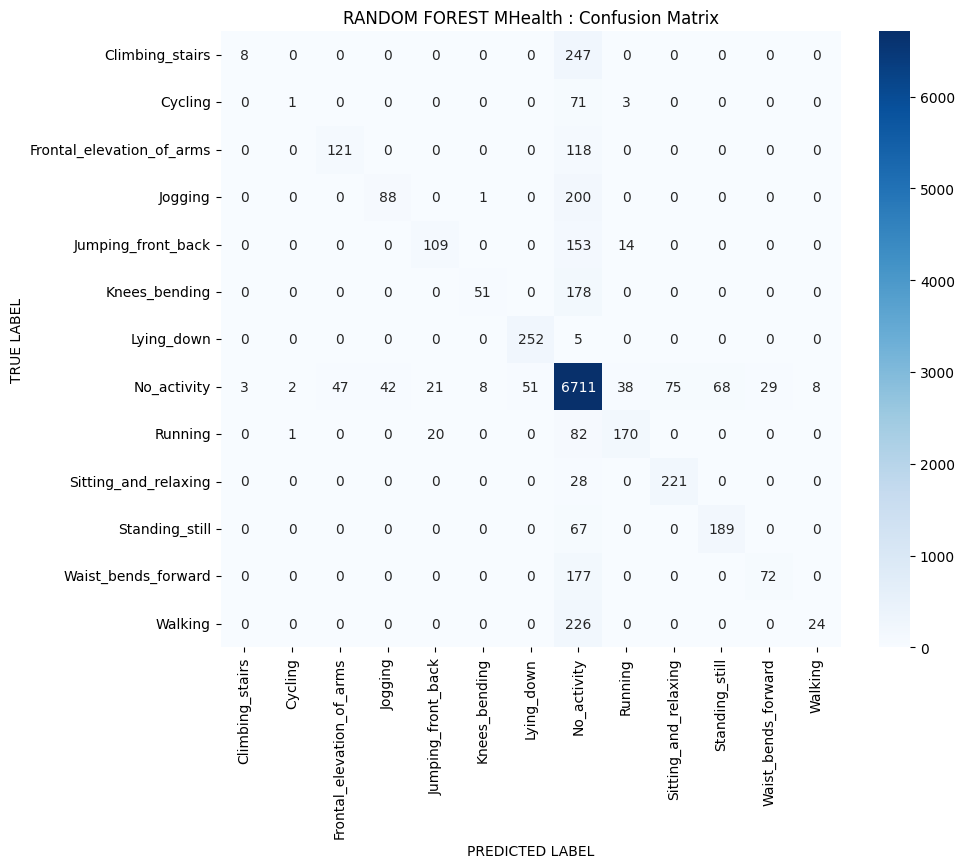

.....................................................!
Running for Advanced SVM.....................>>>>>
.....................................................!


'SVM: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.68,0.10,0.18,255.00
CYCLING,0.29,0.13,0.18,75.00
FRONTAL_ELEVATION_OF_ARMS,0.71,0.60,0.65,239.00
JOGGING,0.69,0.46,0.55,289.00
JUMPING_FRONT_BACK,0.69,0.59,0.64,276.00
KNEES_BENDING,0.82,0.35,0.49,229.00
LYING_DOWN,0.74,1.00,0.85,257.00
NO_ACTIVITY,0.81,0.93,0.87,7103.00
RUNNING,0.76,0.67,0.71,273.00
SITTING_AND_RELAXING,0.64,0.54,0.59,249.00


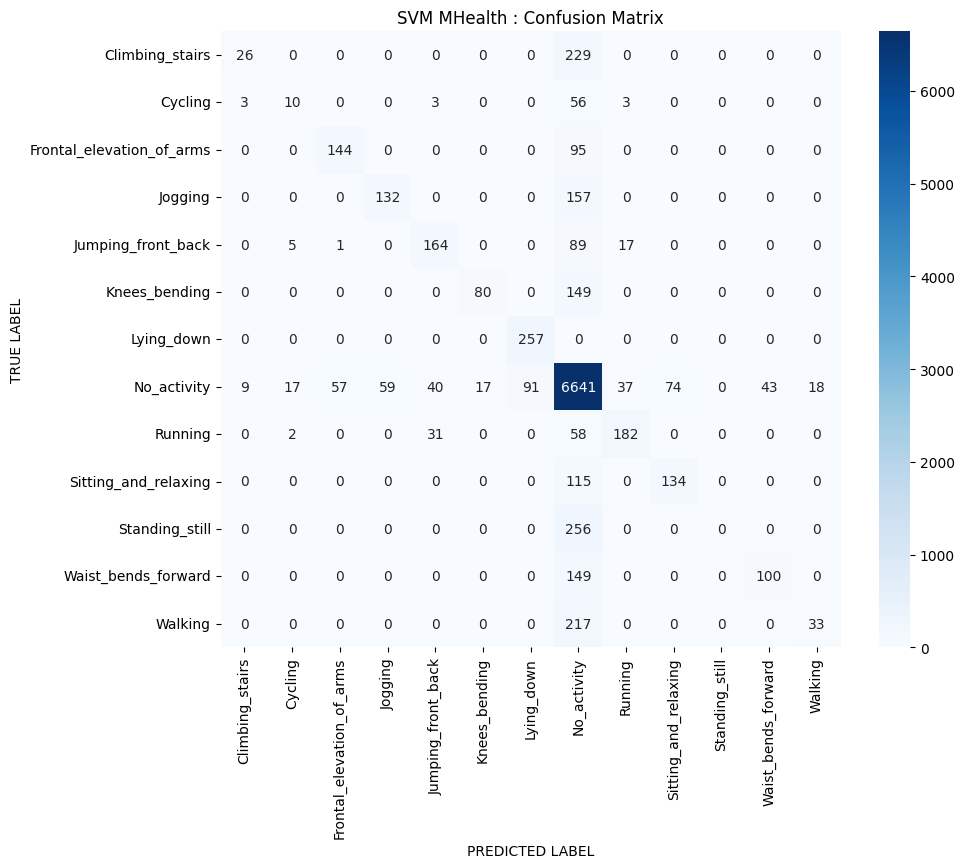

.....................................................!
Running for Advanced LSTM.....................>>>>>
.....................................................!
Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 0.8151 - accuracy: 0.7407 - val_loss: 0.6618 - val_accuracy: 0.7580
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 0.6024 - accuracy: 0.7680 - val_loss: 0.6197 - val_accuracy: 0.7598
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 0.5459 - accuracy: 0.7836 - val_loss: 0.5772 - val_accuracy: 0.7692
Epoch 4/10
500/500 [==============================] - 1s 3ms/step - loss: 0.5133 - accuracy: 0.7895 - val_loss: 0.5576 - val_accuracy: 0.7809
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 0.4820 - accuracy: 0.8023 - val_loss: 0.5678 - val_accuracy: 0.7714
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 0.4613 - accuracy: 0.8078 - val_loss: 0.5630 - val_acc

'LSTM: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.51,0.25,0.34,255.00
CYCLING,0.38,0.24,0.30,75.00
FRONTAL_ELEVATION_OF_ARMS,0.65,0.69,0.67,239.00
JOGGING,0.58,0.62,0.60,289.00
JUMPING_FRONT_BACK,0.54,0.40,0.46,276.00
KNEES_BENDING,0.69,0.48,0.57,229.00
LYING_DOWN,0.76,0.98,0.85,257.00
NO_ACTIVITY,0.85,0.88,0.86,7103.00
RUNNING,0.70,0.62,0.66,273.00
SITTING_AND_RELAXING,0.71,0.90,0.79,249.00


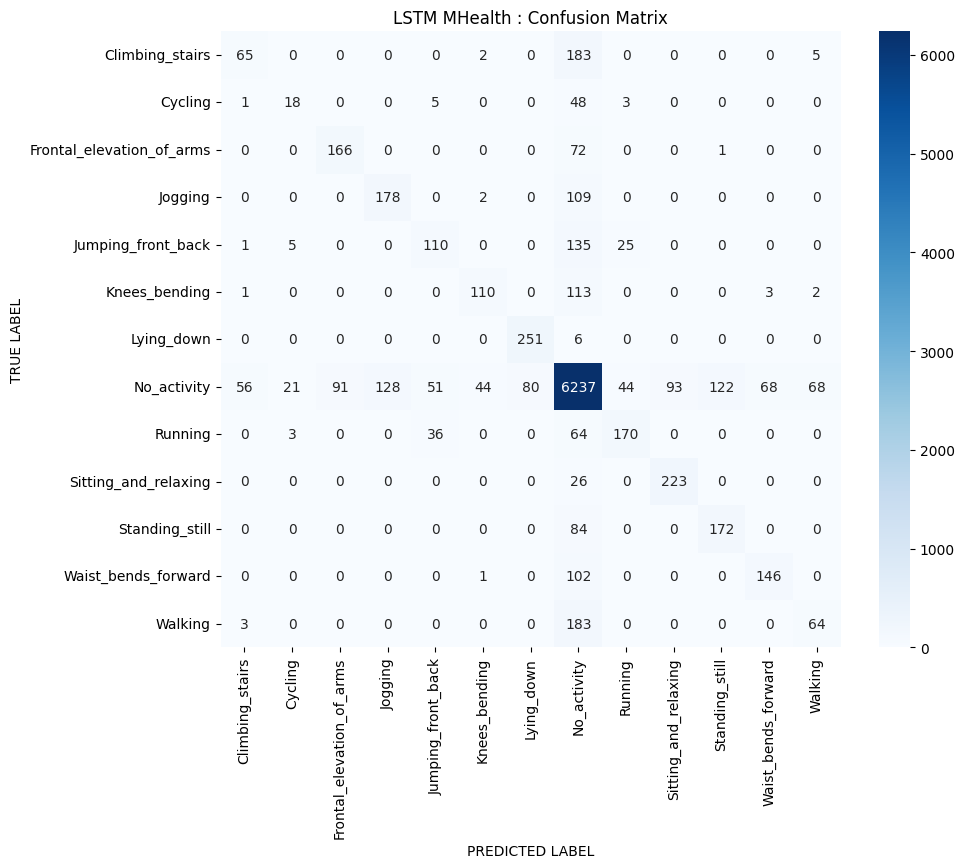

.....................................................!
Running for Advanced CNN.....................>>>>>
.....................................................!
Epoch 1/10
500/500 [==============================] - 13s 26ms/step - loss: 0.7857 - accuracy: 0.7452 - val_loss: 0.6403 - val_accuracy: 0.7620
Epoch 2/10
500/500 [==============================] - 13s 25ms/step - loss: 0.5819 - accuracy: 0.7796 - val_loss: 0.6118 - val_accuracy: 0.7730
Epoch 3/10
500/500 [==============================] - 13s 25ms/step - loss: 0.5213 - accuracy: 0.7922 - val_loss: 0.5793 - val_accuracy: 0.7804
Epoch 4/10
500/500 [==============================] - 13s 25ms/step - loss: 0.4750 - accuracy: 0.8097 - val_loss: 0.5850 - val_accuracy: 0.7735
Epoch 5/10
500/500 [==============================] - 13s 25ms/step - loss: 0.4351 - accuracy: 0.8242 - val_loss: 0.5851 - val_accuracy: 0.7864
Epoch 6/10
500/500 [==============================] - 13s 25ms/step - loss: 0.3988 - accuracy: 0.8349 - val_loss: 0.559

'CNN: Classification Report.'

,PRECISION,RECALL,F1-SCORE,SUPPORT
CLIMBING_STAIRS,0.42,0.24,0.31,255.00
CYCLING,0.28,0.25,0.27,75.00
FRONTAL_ELEVATION_OF_ARMS,0.62,0.54,0.58,239.00
JOGGING,0.63,0.49,0.55,289.00
JUMPING_FRONT_BACK,0.66,0.49,0.56,276.00
KNEES_BENDING,0.51,0.59,0.55,229.00
LYING_DOWN,0.74,1.00,0.85,257.00
NO_ACTIVITY,0.85,0.86,0.85,7103.00
RUNNING,0.70,0.62,0.66,273.00
SITTING_AND_RELAXING,0.71,0.81,0.76,249.00


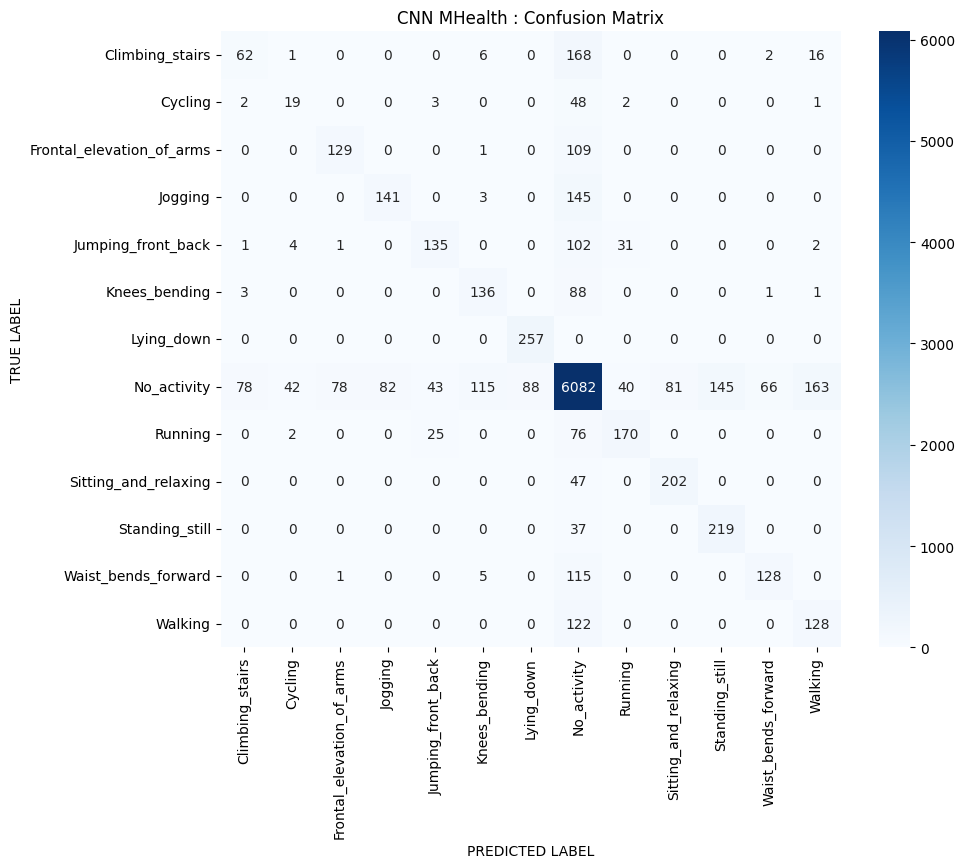

In [17]:
print("\033[1;32m..........................TRAINING CPC...........................!\033[0m")
callModels('CPC','RANDOM FOREST')
callModels('CPC','SVM')
callModels('CPC','LSTM')
callModels('CPC','CNN')